# Yelp Data 

Import the python scientific suite

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')

In [284]:
def CountInstance(df, col_name):

    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)

def TopChains(df, cutoff):
    #
    # Find the top chains
    # include a dataframe with column 'business_name'
    
    name, counts = np.unique(df['name'], return_counts = True)
    counts_df = pd.DataFrame(data = {'name': name, 'counts':counts})
    top_chains = counts_df.sort_values(by = 'counts', ascending = False)
    top_chains.index = range(len(top_chains)) #re-index
    
    return list(top_chains['name'][top_chains['counts'] > cutoff])

def OrderName(df, order_col, order_on):

    ordr = [] #median
    nme = [] #name

    for name in (np.unique(df[order_col])):
        nme.append(name)
        ordr.append(np.mean(df[df[order_col] == name][order_on].dropna()))

    order = list(pd.DataFrame([nme,ordr]).T.sort_values(by = 1)[0])
    
    return(order)

In [294]:
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'

r = pd.read_csv(file_dir + 'review_without_text_year.csv')
b = pd.read_csv('yelp_business_with_neighborhood.csv')
s = pd.read_csv('static_stats.csv')
u = pd.read_csv(file_dir + 'yelp_academic_dataset_user.csv')
#r = pd.read_csv('clean_reviews_neighborhood.csv')

In [295]:
b = CountInstance(b, 'z_hood') #add number of resturants per neighborhood column
r = CountInstance(r, 'business_id') 

In [299]:
min_business_per_neighborhood = 2
min_reviews_per_business = 5
min_stores_per_chain = 40
min_reviews_per_user = 100

bf = b[(b['n_z_hood'] >= min_business_per_neighborhood)]
tc = TopChains(bf, min_stores_per_chain) #compute the top chains
bf = bf[bf['name'].isin(tc)] #filter to just the top chains
rf = pd.merge(r, bf, on = 'business_id', how = 'inner') #find just these reviews
rf = rf[(rf['n_business_id'] > min_reviews_per_business)]

uf = u[(u['review_count'] > min_reviews_per_user)]
rfu = pd.merge(rf, uf, on = 'user_id', how = 'inner')

rs = pd.merge(rfu, s, on = 'z_hood', how = 'inner')
bs = pd.merge(bf, s, on = 'z_hood', how = 'inner')

In [300]:
sns.lmplot(x = 'latest_zhvi', y = 'stars_x', col = 'name', col_wrap = 3, data = rs)
sns.despine()

KeyError: "['name'] not in index"

In [285]:
mean_order = OrderName(bs, 'name', 'latest_zhvi') #order the top chains by mean business zhvi

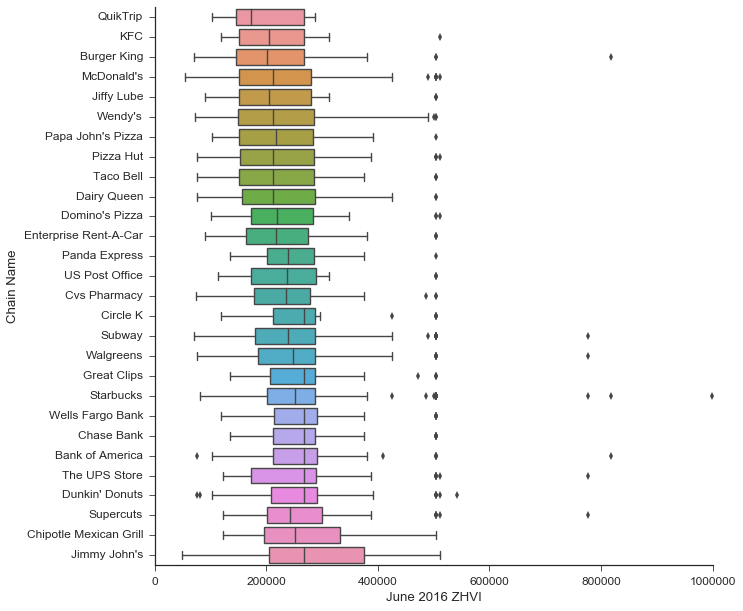

In [287]:
pylab.rcParams['figure.figsize'] = (10.0, 10.0) #set figure parameters
sns.boxplot(data = bs, x = 'latest_zhvi', y = 'name', order = mean_order)
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Chain Name')
sns.despine()
plt.savefig('rich_and_poor_chains.png', dpi = 300, fmt = 'png')